Finally, we are at the modeling phase. Here, I will complete the steps to produce a recommender based on a single movie, and test how well the recommender performs based on the Movielens dataset.

First, I import the necessary libraries.

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_similarity

Now, I import the relevant files that were the output of previous steps.

In [8]:
movielens_movies = pd.read_csv("movies_everything_new.csv")
title_id = movielens_movies[['title','movieId']]
title_id['title'] = title_id['title'].str.lower()

title_id = title_id.set_index('movieId')

print(movielens_movies.shape)

ratings = pd.read_csv('ratings1000.csv')
words = pd.read_csv('all_words_final.csv')

<ipython-input-8-a1ac1c318feb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  title_id['title'] = title_id['title'].str.lower()


(9821, 103)


I create a pivot table for the words dataframe, with movieId as the index, and each word as a column, with the entries being the number of times each word has appeared in the movie's reviews.

In [9]:
words_pivot = words.pivot(index='movieId',columns='Word',values='Count').fillna(0)
scaler = StandardScaler()

Here, I pick an example movie to illustrate the recommender in action.

In [10]:
moviename = "pride & prejudice"
moviename = moviename.lower()

I separate the available movies into the target movie and the remaining movies minus the target movie.

In [11]:
movielens_movies = movielens_movies.set_index('movieId')

movie_id = title_id.index[title_id['title'] == moviename.lower()].values[0]
print(movie_id)

train_movies = movielens_movies

movie_value = train_movies[train_movies.index == movie_id]
remaining_movies = train_movies[train_movies.index != movie_id]

40629


I now extract the movies that have a suitable age rating, and belong to the cluster, supercluster, and megacluster corresponding to the target movie. Reminder that these clusters take both genre and release date into consideration, and naturally that the supercluster contains multiple clusters, and the megacluster contains multiple superclusters. The algorithm will start with the cluster, and then select the supercluster if the cluster contains insufficient matching movies, etc.

In [48]:
rating = movie_value['age_rating'].replace(' ','').iloc[0]
cluster = movie_value['combined_cluster'].iloc[0]
supercluster = movie_value['combined_supercluster'].iloc[0]
megacluster = movie_value['combined_megacluster'].iloc[0]

print(rating)

if rating == 'G':
    remaining_movies = remaining_movies[(remaining_movies['age_rating'] == 'G') | (remaining_movies['age_rating'] == 'PG')]
elif rating == 'PG':
    remaining_movies = remaining_movies[(remaining_movies['age_rating'] == 'G') | (remaining_movies['age_rating'] == 'PG') | (remaining_movies['age_rating'] == 'Passed') | (remaining_movies['age_rating'] == 'PG-13') | (remaining_movies['age_rating'] == 'Unknown')]
elif rating == 'PG-13':
    remaining_movies = remaining_movies[(remaining_movies['age_rating'] == 'PG') | (remaining_movies['age_rating'] == 'PG-13') | (remaining_movies['age_rating'] == 'Unknown') | (remaining_movies['age_rating'] == 'Passed')]
elif rating == 'R':
    remaining_movies = remaining_movies[(remaining_movies['age_rating'] == 'R') | (remaining_movies['age_rating'] == 'Unknown') | (remaining_movies['age_rating'] == 'Passed')]
elif rating == 'NC-17':
    remaining_movies = remaining_movies[(remaining_movies['age_rating'] == 'R') | (remaining_movies['age_rating'] == 'NC-17')]

movies_similar = remaining_movies[remaining_movies['combined_cluster'] == cluster]                              

if len(movies_similar) < 30:
    movies_similar = remaining_movies[remaining_movies['combined_supercluster'] == supercluster]
if len(movies_similar) < 30:
    movies_similar = remaining_movies[remaining_movies['combined_megacluster'] == megacluster]
    
print(movies_similar)

PG
         Unnamed: 0     imdbId                   title age_rating  \
movieId                                                             
3225           2483  tt0186975             Down to You      PG-13   
3299           2536  tt0162983              Hanging Up      PG-13   
3325           2552  tt0156841     The Next Best Thing      PG-13   
3453           2648  tt0195778           Here on Earth      PG-13   
3454           2649  tt0202402       Whatever It Takes      PG-13   
...             ...        ...                     ...        ...   
173205         9721  tt5536736  The Meyerowitz Stories    Unknown   
173209         9722  tt4758646             War Machine    Unknown   
174909         9731  tt5439796             Logan Lucky      PG-13   
177237         9753  tt4622512     Battle of the Sexes      PG-13   
184997         9804  tt5164432             Love, Simon      PG-13   

         time_minutes                                     genres  imdb_score  \
movieId            

After determining the final list of matching movies, I normalize the word scores for each movie, and use cosine similarity to determine the 'closest' movies in terms of their review content. From this, I select the 20 closest movies. I then choose from these the five movies with the highest imdb rating. In this way, I take into account both similarity to the original movie, and overall quality, both of which are valuable when making recommendations.

In [49]:
final_movies = movies_similar
#final_movies = remaining_movies

movie_options = words_pivot[words_pivot.index.isin(final_movies.index)]

movie_wanted = normalize(words_pivot[words_pivot.index == movie_id])

movie_options_norm = normalize(movie_options)
movie_options = pd.DataFrame(movie_options_norm,columns=movie_options.columns,index=movie_options.index)

cos_sim = cosine_similarity(movie_options,movie_wanted)
cos_sim = pd.Series(cos_sim.flatten(),index=movie_options.index)

suggested_movies = cos_sim.nlargest(20)
    

print(suggested_movies)

print(movielens_movies[movielens_movies.index.isin(suggested_movies.index)].nlargest(5,'imdb_score')['title'])

movieId
132961    0.431163
74508     0.324404
85438     0.323742
5527      0.314689
55451     0.294387
6493      0.289023
5380      0.283513
53988     0.272103
63853     0.269853
50066     0.265588
164909    0.258376
51834     0.256470
36535     0.256237
93740     0.252310
60758     0.251333
104906    0.249101
88163     0.248326
50160     0.245366
100487    0.244600
51705     0.244177
dtype: float64
movieId
164909                   La La Land
74508                    Persuasion
36535     Everything Is Illuminated
88163          Crazy, Stupid, Love.
85438                     Jane Eyre
Name: title, dtype: object


The resulting movies appear to be strong matches, being both highly rated and having elements of romance. This is the genre clusters at work, which are necessary to ensure a baseline similarity between the movie input and the suggested movies. The similarity score between movie reviews looks for more specific movie information overlap, and incorporating imdb score into the selection process ensures that high quality movies will be recommended.

Now it's time to test the recommendations using the Movielens data.

In [10]:
print(movielens_movies)

         Unnamed: 0     imdbId                          title age_rating  \
movieId                                                                    
1                 0  tt0114709                      Toy Story          G   
2                 1  tt0113497                        Jumanji         PG   
3                 2  tt0113228               Grumpier Old Men      PG-13   
4                 3  tt0114885              Waiting to Exhale          R   
5                 4  tt0113041    Father of the Bride Part II         PG   
...             ...        ...                            ...        ...   
189041         9816  tt5052474    Sicario: Day of the Soldado          R   
189203         9817  tt6499752                        Upgrade          R   
189333         9818  tt4912910  Mission: Impossible - Fallout      PG-13   
189363         9819  tt5164214                  Ocean's Eight      PG-13   
189713         9820  tt7349662                 BlacKkKlansman          R   

         ti

In addition to testing the full model, I will also test three other incomplete models for comparison.

I will be using three different metrics to evaluate the models:

The first is the average standardized score of the recommended movies. I will establish this score via testing the model on the users from the MovieLens dataset. First, I will standardize the scores the users give to each movie. Then, I will iterate through all the users, picking 10 randomly sampled movies for each user, and average the standardized score of the movies returned by the model. For the random model, the standardized score would feasibly be around zero, while a performant model would want as high a score as possible.

The second will be coverage, which is simply how much of the entire movie catalog is within the recommendation space.

The third will be personalization, which measures how different the recommendations are for each user on average.

I will begin by constructing a matrix with the movie ids as both indices and columns. An index,column entry will be 1 if the column movie is recommended for the index movie, otherwise 0. This will allow me to calculate both coverage and personalization.

I begin with the full model.

In [6]:
ratings_pivot = ratings.pivot(index='userId',columns='movieId',values='rating')
trainusers = ratings_pivot

unique_movies = set()
totalcount = 0
totalscore = 0

personalization_matrix = pd.DataFrame(columns=movielens_movies.index,index=movielens_movies.index)

In [ ]:
count = 0

for movie_id in movielens_movies.index:
    print(count)
    print(movie_id)
    train_movies = movielens_movies

    movie_value = train_movies[train_movies.index == movie_id]
    remaining_movies = train_movies[train_movies.index != movie_id]
    
    rating = movie_value['age_rating'].replace(' ','').iloc[0]
    cluster = movie_value['combined_cluster'].iloc[0]
    supercluster = movie_value['combined_supercluster'].iloc[0]
    megacluster = movie_value['combined_megacluster'].iloc[0]

    #print(rating)

    if rating == 'G':
        remaining_movies = remaining_movies[(remaining_movies['age_rating'] == 'G') | (remaining_movies['age_rating'] == 'PG')]
    elif rating == 'PG':
        remaining_movies = remaining_movies[(remaining_movies['age_rating'] == 'G') | (remaining_movies['age_rating'] == 'PG') | (remaining_movies['age_rating'] == 'Passed') | (remaining_movies['age_rating'] == 'PG-13') | (remaining_movies['age_rating'] == 'Unknown')]
    elif rating == 'PG-13':
        remaining_movies = remaining_movies[(remaining_movies['age_rating'] == 'PG') | (remaining_movies['age_rating'] == 'PG-13') | (remaining_movies['age_rating'] == 'Unknown') | (remaining_movies['age_rating'] == 'Passed')]
    elif rating == 'R':
        remaining_movies = remaining_movies[(remaining_movies['age_rating'] == 'R') | (remaining_movies['age_rating'] == 'Unknown') | (remaining_movies['age_rating'] == 'Passed')]
    elif rating == 'NC-17':
        remaining_movies = remaining_movies[(remaining_movies['age_rating'] == 'R') | (remaining_movies['age_rating'] == 'NC-17')]

    movies_similar = remaining_movies[remaining_movies['combined_cluster'] == cluster]                              

    if len(movies_similar) < 30:
        movies_similar = remaining_movies[remaining_movies['combined_supercluster'] == supercluster]
    if len(movies_similar) < 30:
        movies_similar = remaining_movies[remaining_movies['combined_megacluster'] == megacluster]
    if len(movies_similar) < 20:
        movies_similar = remaining_movies
    #print(movies_similar)
    
    final_movies = movies_similar

    movie_options = words_pivot[words_pivot.index.isin(final_movies.index)]

    movie_wanted = normalize(words_pivot[words_pivot.index == movie_id])

    movie_options_norm = normalize(movie_options)
    movie_options = pd.DataFrame(movie_options_norm,columns=movie_options.columns,index=movie_options.index)

    cos_sim = cosine_similarity(movie_options,movie_wanted)
    cos_sim = pd.Series(cos_sim.flatten(),index=movie_options.index)

    suggested_movies = cos_sim.nlargest(20)
    

    #print(suggested_movies)
    
    for movie in movielens_movies[movielens_movies.index.isin(suggested_movies.index)].nlargest(5,'imdb_score').index:
        personalization_matrix.loc[movie_id,movie] = 1

    #print(movielens_movies[movielens_movies.index.isin(suggested_movies.index)].nlargest(5,'imdb_score')['title'])
    count += 1

In [22]:
personalization_matrix.to_csv('personalization.csv')

In [24]:
personalization_matrix = personalization_matrix.fillna(0)

In [25]:
personalization_similarity = cosine_similarity(personalization_matrix)

In [27]:
print(personalization_similarity[0])

[1.  0.2 0.  ... 0.  0.  0. ]


Here, I calculate the personalization for the full model. It's 0.997, indicating that the results are extremely personalized, there is very little consistent overlap between recommendations.

In [29]:
upper_right = np.triu_indices(personalization_similarity.shape[0], k=1)


personalization = np.mean(personalization_similarity[upper_right])
print(1-personalization)

0.9971966012395815


Next, I calculate the personalization matrix for a model which doesn't filter using the review keywords, and just picks the top 5 movies from their respective genre cluster.

In [30]:
unique_movies = set()
totalcount = 0
totalscore = 0

personalization_matrix_no_words = pd.DataFrame(columns=movielens_movies.index,index=movielens_movies.index)

In [ ]:
count = 0

for movie_id in movielens_movies.index:
    print(count)
    print(movie_id)
    train_movies = movielens_movies

    movie_value = train_movies[train_movies.index == movie_id]
    remaining_movies = train_movies[train_movies.index != movie_id]
    
    rating = movie_value['age_rating'].replace(' ','').iloc[0]
    cluster = movie_value['combined_cluster'].iloc[0]
    supercluster = movie_value['combined_supercluster'].iloc[0]
    megacluster = movie_value['combined_megacluster'].iloc[0]

    #print(rating)

    if rating == 'G':
        remaining_movies = remaining_movies[(remaining_movies['age_rating'] == 'G') | (remaining_movies['age_rating'] == 'PG')]
    elif rating == 'PG':
        remaining_movies = remaining_movies[(remaining_movies['age_rating'] == 'G') | (remaining_movies['age_rating'] == 'PG') | (remaining_movies['age_rating'] == 'Passed') | (remaining_movies['age_rating'] == 'PG-13') | (remaining_movies['age_rating'] == 'Unknown')]
    elif rating == 'PG-13':
        remaining_movies = remaining_movies[(remaining_movies['age_rating'] == 'PG') | (remaining_movies['age_rating'] == 'PG-13') | (remaining_movies['age_rating'] == 'Unknown') | (remaining_movies['age_rating'] == 'Passed')]
    elif rating == 'R':
        remaining_movies = remaining_movies[(remaining_movies['age_rating'] == 'R') | (remaining_movies['age_rating'] == 'Unknown') | (remaining_movies['age_rating'] == 'Passed')]
    elif rating == 'NC-17':
        remaining_movies = remaining_movies[(remaining_movies['age_rating'] == 'R') | (remaining_movies['age_rating'] == 'NC-17')]

    movies_similar = remaining_movies[remaining_movies['combined_cluster'] == cluster]                              

    if len(movies_similar) < 30:
        movies_similar = remaining_movies[remaining_movies['combined_supercluster'] == supercluster]
    if len(movies_similar) < 30:
        movies_similar = remaining_movies[remaining_movies['combined_megacluster'] == megacluster]
    if len(movies_similar) < 20:
        movies_similar = remaining_movies
    #print(movies_similar)
    
    final_movies = movies_similar

    movie_options = words_pivot[words_pivot.index.isin(final_movies.index)]

    movie_wanted = normalize(words_pivot[words_pivot.index == movie_id])

    movie_options_norm = normalize(movie_options)
    movie_options = pd.DataFrame(movie_options_norm,columns=movie_options.columns,index=movie_options.index)

    #cos_sim = cosine_similarity(movie_options,movie_wanted)
    #cos_sim = pd.Series(cos_sim.flatten(),index=movie_options.index)

    suggested_movies = movie_options
    

    #print(suggested_movies)
    
    for movie in movielens_movies[movielens_movies.index.isin(suggested_movies.index)].nlargest(5,'imdb_score').index:
        personalization_matrix_no_words.loc[movie_id,movie] = 1

    #print(movielens_movies[movielens_movies.index.isin(suggested_movies.index)].nlargest(5,'imdb_score')['title'])
    count += 1

In [32]:
personalization_matrix_no_words = personalization_matrix_no_words.fillna(0)

In [35]:
personalization_matrix_no_words.to_csv('personalization_matrix_no_words.csv')

In [33]:
personalization_similarity_no_words = cosine_similarity(personalization_matrix_no_words)

In [38]:
column_sums = personalization_matrix.sum(axis=0)

In [40]:
column_sums_count = column_sums[column_sums > 0].count()

Here is the coverage score for the full model. I apologize for these cells being somewhat out of order.

This means that the full model covers over 40% of the catalog.

In [42]:
column_sums_count/len(column_sums)

0.41329803482333777

In [43]:
column_sums_no_words = personalization_matrix_no_words.sum(axis=0)

In [44]:
column_sums_no_words_count = column_sums_no_words[column_sums_no_words > 0].count()

Conversely, the model which chooses the top 5 movies from the genre cluster only covers less than 5% of the catalog, a very significant decrease.

Coverage is important because a movie streaming service is going to want to maximize the period that their customers remain interested, and thus take advantage of as many movies in their catalog as they can.

In [45]:
column_sums_no_words_count/len(column_sums_no_words)

0.048365746868954285

The personalization score for the model without keyword filtering is also high, though lower than for the full model. Given how many movies are being compared, this decrease is actually more significant than it looks via the score.

In [34]:
upper_right = np.triu_indices(personalization_similarity_no_words.shape[0], k=1)


personalization = np.mean(personalization_similarity_no_words[upper_right])
print(1-personalization)

0.9710645980567432


Now I test a model without word filtering or genre information, that just takes the top 5 after partitioning the movies by age rating (which is always necessary).

In [56]:
unique_movies = set()
totalcount = 0
totalscore = 0

personalization_matrix_top_5 = pd.DataFrame(columns=movielens_movies.index,index=movielens_movies.index)

In [ ]:
count = 0

for movie_id in movielens_movies.index:
    print(count)
    print(movie_id)
    train_movies = movielens_movies

    movie_value = train_movies[train_movies.index == movie_id]
    remaining_movies = train_movies[train_movies.index != movie_id]
    
    rating = movie_value['age_rating'].replace(' ','').iloc[0]
    cluster = movie_value['combined_cluster'].iloc[0]
    supercluster = movie_value['combined_supercluster'].iloc[0]
    megacluster = movie_value['combined_megacluster'].iloc[0]

    #print(rating)

    if rating == 'G':
        remaining_movies = remaining_movies[(remaining_movies['age_rating'] == 'G') | (remaining_movies['age_rating'] == 'PG')]
    elif rating == 'PG':
        remaining_movies = remaining_movies[(remaining_movies['age_rating'] == 'G') | (remaining_movies['age_rating'] == 'PG') | (remaining_movies['age_rating'] == 'Passed') | (remaining_movies['age_rating'] == 'PG-13') | (remaining_movies['age_rating'] == 'Unknown')]
    elif rating == 'PG-13':
        remaining_movies = remaining_movies[(remaining_movies['age_rating'] == 'PG') | (remaining_movies['age_rating'] == 'PG-13') | (remaining_movies['age_rating'] == 'Unknown') | (remaining_movies['age_rating'] == 'Passed')]
    elif rating == 'R':
        remaining_movies = remaining_movies[(remaining_movies['age_rating'] == 'R') | (remaining_movies['age_rating'] == 'Unknown') | (remaining_movies['age_rating'] == 'Passed')]
    elif rating == 'NC-17':
        remaining_movies = remaining_movies[(remaining_movies['age_rating'] == 'R') | (remaining_movies['age_rating'] == 'NC-17')]

    movies_similar = remaining_movies[remaining_movies['combined_cluster'] == cluster]                              

    if len(movies_similar) < 30:
        movies_similar = remaining_movies[remaining_movies['combined_supercluster'] == supercluster]
    if len(movies_similar) < 30:
        movies_similar = remaining_movies[remaining_movies['combined_megacluster'] == megacluster]
    if len(movies_similar) < 20:
        movies_similar = remaining_movies
    #print(movies_similar)
    
    final_movies = remaining_movies

    movie_options = words_pivot[words_pivot.index.isin(final_movies.index)]

    movie_wanted = normalize(words_pivot[words_pivot.index == movie_id])

    movie_options_norm = normalize(movie_options)
    movie_options = pd.DataFrame(movie_options_norm,columns=movie_options.columns,index=movie_options.index)

    #cos_sim = cosine_similarity(movie_options,movie_wanted)
    #cos_sim = pd.Series(cos_sim.flatten(),index=movie_options.index)

    suggested_movies = movie_options
    

    #print(suggested_movies)
    
    for movie in movielens_movies[movielens_movies.index.isin(suggested_movies.index)].nlargest(5,'imdb_score').index:
        personalization_matrix_top_5.loc[movie_id,movie] = 1

    #print(movielens_movies[movielens_movies.index.isin(suggested_movies.index)].nlargest(5,'imdb_score')['title'])
    count += 1

In [58]:
personalization_matrix_top_5 = personalization_matrix_top_5.fillna(0)

In [59]:
personalization_matrix_top_5.to_csv('personalization_matrix_top_5.csv')

In [60]:
personalization_similarity_top_5 = cosine_similarity(personalization_matrix_top_5)

In [61]:
column_sums_top_5 = personalization_matrix_top_5.sum(axis=0)

In [62]:
column_sums_top_5_count = column_sums_top_5[column_sums_top_5 > 0].count()

As expected, the coverage is extremely low, less than 0.2% of the total catalog.

In [63]:
column_sums_top_5_count/len(column_sums_top_5)

0.0016291619997963547

The personalization is also much lower than the other models, which means many movies are resulting in the same recommendations being generated.

In [64]:
upper_right = np.triu_indices(personalization_similarity_top_5.shape[0], k=1)


personalization = np.mean(personalization_similarity_top_5[upper_right])
print(1-personalization)

0.41701563900126026


Finally, I test a random model, which separates the movies into genre clusters, then chooses 5 movies from the suitable cluster at random.

I'm including this model to show the degree to which filtering improves the model's performance.

In [7]:
unique_movies = set()
totalcount = 0
totalscore = 0

personalization_matrix_random = pd.DataFrame(columns=movielens_movies.index,index=movielens_movies.index)

In [ ]:
count = 0

for movie_id in movielens_movies.index:
    print(count)
    print(movie_id)
    train_movies = movielens_movies

    movie_value = train_movies[train_movies.index == movie_id]
    remaining_movies = train_movies[train_movies.index != movie_id]
    
    rating = movie_value['age_rating'].replace(' ','').iloc[0]
    cluster = movie_value['combined_cluster'].iloc[0]
    supercluster = movie_value['combined_supercluster'].iloc[0]
    megacluster = movie_value['combined_megacluster'].iloc[0]

    #print(rating)

    if rating == 'G':
        remaining_movies = remaining_movies[(remaining_movies['age_rating'] == 'G') | (remaining_movies['age_rating'] == 'PG')]
    elif rating == 'PG':
        remaining_movies = remaining_movies[(remaining_movies['age_rating'] == 'G') | (remaining_movies['age_rating'] == 'PG') | (remaining_movies['age_rating'] == 'Passed') | (remaining_movies['age_rating'] == 'PG-13') | (remaining_movies['age_rating'] == 'Unknown')]
    elif rating == 'PG-13':
        remaining_movies = remaining_movies[(remaining_movies['age_rating'] == 'PG') | (remaining_movies['age_rating'] == 'PG-13') | (remaining_movies['age_rating'] == 'Unknown') | (remaining_movies['age_rating'] == 'Passed')]
    elif rating == 'R':
        remaining_movies = remaining_movies[(remaining_movies['age_rating'] == 'R') | (remaining_movies['age_rating'] == 'Unknown') | (remaining_movies['age_rating'] == 'Passed')]
    elif rating == 'NC-17':
        remaining_movies = remaining_movies[(remaining_movies['age_rating'] == 'R') | (remaining_movies['age_rating'] == 'NC-17')]

    movies_similar = remaining_movies[remaining_movies['combined_cluster'] == cluster]                              

    if len(movies_similar) < 30:
        movies_similar = remaining_movies[remaining_movies['combined_supercluster'] == supercluster]
    if len(movies_similar) < 30:
        movies_similar = remaining_movies[remaining_movies['combined_megacluster'] == megacluster]
    if len(movies_similar) < 20:
        movies_similar = remaining_movies
    #print(movies_similar)
    
    final_movies = movies_similar

    movie_options = words_pivot[words_pivot.index.isin(final_movies.index)]

    movie_wanted = normalize(words_pivot[words_pivot.index == movie_id])

    movie_options_norm = normalize(movie_options)
    movie_options = pd.DataFrame(movie_options_norm,columns=movie_options.columns,index=movie_options.index)

    #cos_sim = cosine_similarity(movie_options,movie_wanted)
    #cos_sim = pd.Series(cos_sim.flatten(),index=movie_options.index)

    suggested_movies = movie_options
    

    #print(suggested_movies)
    
    for movie in movielens_movies[movielens_movies.index.isin(suggested_movies.index)].sample(5).index:
        personalization_matrix_random.loc[movie_id,movie] = 1

    #print(movielens_movies[movielens_movies.index.isin(suggested_movies.index)].nlargest(5,'imdb_score')['title'])
    count += 1

In [9]:
personalization_matrix_random = personalization_matrix_random.fillna(0)

In [10]:
personalization_matrix_random.to_csv('personalization_matrix_random.csv')

In [11]:
personalization_similarity_random = cosine_similarity(personalization_matrix_random)

In [12]:
column_sums_random = personalization_matrix_random.sum(axis=0)
column_sums_random_count = column_sums_random[column_sums_random > 0].count()

As expected, the random model's personalization and coverage are both very high, because there are no constraints on which movies are selected. However, the average score, calculated in the next section, should be a lot lower than the other models, close to zero (since scores have been standardized).

In [13]:
column_sums_random_count/len(column_sums_random)

0.9697586803787802

In [14]:
upper_right = np.triu_indices(personalization_similarity_random.shape[0], k=1)


personalization = np.mean(personalization_similarity_random[upper_right])
print(1-personalization)

0.9994576815009029


Now, I use the MovieLens data to calculate the average scores of the recommended movies for each user.

This code takes quite a while to execute.

In [11]:
ratings_pivot = ratings.pivot(index='userId',columns='movieId',values='rating')

In [ ]:
trainusers = ratings_pivot

unique_movies = set()
totalcount = 0
totalscore = 0

for i in range(len(trainusers)):
    moviecount = 0
    user = trainusers.iloc[i,:].dropna()
    user_scaled = scaler.fit_transform(user.values.reshape(-1,1))
    #print(user_scaled)
    user_scaled = pd.Series((s[0] for s in user_scaled),index=user.index)
    user_scaled = user_scaled.sample(frac=1)
    train_movies = movielens_movies
    train_movies = train_movies[train_movies.index.isin(user_scaled.index)]
    for movie in user_scaled.index:
        # print(movie)
        # print(moviecount)
        if moviecount >= 10:
            break
        if movie not in train_movies.index:
            continue
        if movie not in words_pivot.index:
            continue
        #print(movie)
        movie_value = train_movies[train_movies.index == movie]
        remaining_movies = train_movies[train_movies.index != movie]
        #print(len(remaining_movies))
        cluster = movie_value['combined_cluster'].iloc[0]
        supercluster = movie_value['combined_supercluster'].iloc[0]
        megacluster = movie_value['combined_megacluster'].iloc[0]

        rating = movie_value['age_rating'].iloc[0]

        if rating == 'G':
            remaining_movies = remaining_movies[(remaining_movies['age_rating'] == 'G') | (remaining_movies['age_rating'] == 'PG')]
        elif rating == 'PG':
            remaining_movies = remaining_movies[(remaining_movies['age_rating'] == 'G') | (remaining_movies['age_rating'] == 'PG') | (remaining_movies['age_rating'] == 'Passed') | (remaining_movies['age_rating'] == 'PG-13') | (remaining_movies['age_rating'] == 'Unknown')]
        elif rating == 'PG-13':
            remaining_movies = remaining_movies[(remaining_movies['age_rating'] == 'R') | (remaining_movies['age_rating'] == 'PG') | (remaining_movies['age_rating'] == 'PG-13') | (remaining_movies['age_rating'] == 'Unknown') | (remaining_movies['age_rating'] == 'Passed')]
        elif rating == 'R':
            remaining_movies = remaining_movies[(remaining_movies['age_rating'] == 'R') | (remaining_movies['age_rating'] == 'Unknown') | (remaining_movies['age_rating'] == 'Passed')]
        elif rating == 'NC-17':
            remaining_movies = remaining_movies[(remaining_movies['age_rating'] == 'R') | (remaining_movies['age_rating'] == 'NC-17')]
        else:
            remaining_movies = remaining_movies[(remaining_movies['age_rating'] == 'PG-13') | (remaining_movies['age_rating'] == 'Unknown') | (remaining_movies['age_rating'] == 'Passed')]
        
        movies_similar = remaining_movies[remaining_movies['combined_cluster'] == cluster]   
                           
        if len(movies_similar) < 30:
            movies_similar = remaining_movies[remaining_movies['combined_supercluster'] == supercluster]
        if len(movies_similar) < 30:
            movies_similar = remaining_movies[remaining_movies['combined_megacluster'] == supercluster]
            
        #print(cluster)
        if len(movies_similar) < 20:
            movies_similar = remaining_movies
        #print(len(movies_similar))

        final_movies = movies_similar

        movie_options = words_pivot[words_pivot.index.isin(final_movies.index)]
        
        movie_wanted = normalize(words_pivot[words_pivot.index == movie])
        
        movie_options_norm = normalize(movie_options)
        movie_options = pd.DataFrame(movie_options_norm,columns=movie_options.columns,index=movie_options.index)
        
        cos_sim = cosine_similarity(movie_options,movie_wanted)
        cos_sim = pd.Series(cos_sim.flatten(),index=movie_options.index)
        
        suggested_movies = cos_sim.nlargest(20)
            
        
        #print(suggested_movies)
        
        selected = movielens_movies[movielens_movies.index.isin(suggested_movies.index)].nlargest(5,'imdb_score').index
        #selected = movielens_movies[movielens_movies.index.isin(movie_options.index)].nlargest(5,'imdb_score').index
        score = 0
        for val in selected:
            unique_movies.add(val)
            score = score + user_scaled[val]
            #print(user_scaled[val])
        score = score/5
        totalscore = totalscore + score
        
        moviecount += 1
        totalcount += 1
        
    print(totalcount)
    print(totalscore)
    print(len(unique_movies))

The average score for the full model is approximately 0.5, which means the average recommended movie scores 0.5 standard deviations above the user's mean rating.

In [13]:
totalscore/totalcount

0.4991206455817037

Now, I test the model which ignores the keyword filtering and just takes the top 5 from each genre cluster.

In [ ]:
trainusers = ratings_pivot

unique_movies = set()
totalcount = 0
totalscore = 0

for i in range(len(trainusers)):
    moviecount = 0
    user = trainusers.iloc[i,:].dropna()
    user_scaled = scaler.fit_transform(user.values.reshape(-1,1))
    #print(user_scaled)
    user_scaled = pd.Series((s[0] for s in user_scaled),index=user.index)
    user_scaled = user_scaled.sample(frac=1)
    train_movies = movielens_movies
    train_movies = train_movies[train_movies.index.isin(user_scaled.index)]
    for movie in user_scaled.index:
        # print(movie)
        # print(moviecount)
        if moviecount >= 10:
            break
        if movie not in train_movies.index:
            continue
        if movie not in words_pivot.index:
            continue
        #print(movie)
        movie_value = train_movies[train_movies.index == movie]
        remaining_movies = train_movies[train_movies.index != movie]
        #print(len(remaining_movies))
        cluster = movie_value['combined_cluster'].iloc[0]
        supercluster = movie_value['combined_supercluster'].iloc[0]
        megacluster = movie_value['combined_megacluster'].iloc[0]

        rating = movie_value['age_rating'].iloc[0]

        if rating == 'G':
            remaining_movies = remaining_movies[(remaining_movies['age_rating'] == 'G') | (remaining_movies['age_rating'] == 'PG')]
        elif rating == 'PG':
            remaining_movies = remaining_movies[(remaining_movies['age_rating'] == 'G') | (remaining_movies['age_rating'] == 'PG') | (remaining_movies['age_rating'] == 'Passed') | (remaining_movies['age_rating'] == 'PG-13') | (remaining_movies['age_rating'] == 'Unknown')]
        elif rating == 'PG-13':
            remaining_movies = remaining_movies[(remaining_movies['age_rating'] == 'R') | (remaining_movies['age_rating'] == 'PG') | (remaining_movies['age_rating'] == 'PG-13') | (remaining_movies['age_rating'] == 'Unknown') | (remaining_movies['age_rating'] == 'Passed')]
        elif rating == 'R':
            remaining_movies = remaining_movies[(remaining_movies['age_rating'] == 'R') | (remaining_movies['age_rating'] == 'Unknown') | (remaining_movies['age_rating'] == 'Passed')]
        elif rating == 'NC-17':
            remaining_movies = remaining_movies[(remaining_movies['age_rating'] == 'R') | (remaining_movies['age_rating'] == 'NC-17')]
        else:
            remaining_movies = remaining_movies[(remaining_movies['age_rating'] == 'PG-13') | (remaining_movies['age_rating'] == 'Unknown') | (remaining_movies['age_rating'] == 'Passed')]
        
        movies_similar = remaining_movies[remaining_movies['combined_cluster'] == cluster]   
                           
        if len(movies_similar) < 30:
            movies_similar = remaining_movies[remaining_movies['combined_supercluster'] == supercluster]
        if len(movies_similar) < 30:
            movies_similar = remaining_movies[remaining_movies['combined_megacluster'] == supercluster]
            
        #print(cluster)
        if len(movies_similar) < 20:
            movies_similar = remaining_movies
        #print(len(movies_similar))

        final_movies = movies_similar

        movie_options = words_pivot[words_pivot.index.isin(final_movies.index)]
        
        movie_wanted = normalize(words_pivot[words_pivot.index == movie])
        
        movie_options_norm = normalize(movie_options)
        movie_options = pd.DataFrame(movie_options_norm,columns=movie_options.columns,index=movie_options.index)
        
        #cos_sim = cosine_similarity(movie_options,movie_wanted)
        #cos_sim = pd.Series(cos_sim.flatten(),index=movie_options.index)
        
        suggested_movies = movie_options
            
        
        #print(suggested_movies)
        
        selected = movielens_movies[movielens_movies.index.isin(suggested_movies.index)].nlargest(5,'imdb_score').index
        #selected = movielens_movies[movielens_movies.index.isin(movie_options.index)].nlargest(5,'imdb_score').index
        score = 0
        for val in selected:
            unique_movies.add(val)
            score = score + user_scaled[val]
            #print(user_scaled[val])
        score = score/5
        totalscore = totalscore + score
        
        moviecount += 1
        totalcount += 1
        
    print(totalcount)
    print(totalscore)
    print(len(unique_movies))

The average score is about 0.74, higher than the full model, which is to be expected. The top 5 movies are naturally going to consistently receive high ratings.

In [15]:
totalscore/totalcount

0.7419886979790223

Here, I test the random model.

In [ ]:
trainusers = ratings_pivot

unique_movies = set()
totalcount = 0
totalscore = 0

for i in range(len(trainusers)):
    moviecount = 0
    user = trainusers.iloc[i,:].dropna()
    user_scaled = scaler.fit_transform(user.values.reshape(-1,1))
    #print(user_scaled)
    user_scaled = pd.Series((s[0] for s in user_scaled),index=user.index)
    user_scaled = user_scaled.sample(frac=1)
    train_movies = movielens_movies
    train_movies = train_movies[train_movies.index.isin(user_scaled.index)]
    for movie in user_scaled.index:
        # print(movie)
        # print(moviecount)
        if moviecount >= 10:
            break
        if movie not in train_movies.index:
            continue
        if movie not in words_pivot.index:
            continue
        #print(movie)
        movie_value = train_movies[train_movies.index == movie]
        remaining_movies = train_movies[train_movies.index != movie]
        #print(len(remaining_movies))
        cluster = movie_value['combined_cluster'].iloc[0]
        supercluster = movie_value['combined_supercluster'].iloc[0]
        megacluster = movie_value['combined_megacluster'].iloc[0]

        rating = movie_value['age_rating'].iloc[0]

        if rating == 'G':
            remaining_movies = remaining_movies[(remaining_movies['age_rating'] == 'G') | (remaining_movies['age_rating'] == 'PG')]
        elif rating == 'PG':
            remaining_movies = remaining_movies[(remaining_movies['age_rating'] == 'G') | (remaining_movies['age_rating'] == 'PG') | (remaining_movies['age_rating'] == 'Passed') | (remaining_movies['age_rating'] == 'PG-13') | (remaining_movies['age_rating'] == 'Unknown')]
        elif rating == 'PG-13':
            remaining_movies = remaining_movies[(remaining_movies['age_rating'] == 'R') | (remaining_movies['age_rating'] == 'PG') | (remaining_movies['age_rating'] == 'PG-13') | (remaining_movies['age_rating'] == 'Unknown') | (remaining_movies['age_rating'] == 'Passed')]
        elif rating == 'R':
            remaining_movies = remaining_movies[(remaining_movies['age_rating'] == 'R') | (remaining_movies['age_rating'] == 'Unknown') | (remaining_movies['age_rating'] == 'Passed')]
        elif rating == 'NC-17':
            remaining_movies = remaining_movies[(remaining_movies['age_rating'] == 'R') | (remaining_movies['age_rating'] == 'NC-17')]
        else:
            remaining_movies = remaining_movies[(remaining_movies['age_rating'] == 'PG-13') | (remaining_movies['age_rating'] == 'Unknown') | (remaining_movies['age_rating'] == 'Passed')]
        
        movies_similar = remaining_movies[remaining_movies['combined_cluster'] == cluster]   
                           
        if len(movies_similar) < 30:
            movies_similar = remaining_movies[remaining_movies['combined_supercluster'] == supercluster]
        if len(movies_similar) < 30:
            movies_similar = remaining_movies[remaining_movies['combined_megacluster'] == supercluster]
            
        #print(cluster)
        if len(movies_similar) < 30:
            movies_similar = remaining_movies
        #print(len(movies_similar))

        final_movies = movies_similar

        movie_options = words_pivot[words_pivot.index.isin(final_movies.index)]
        
        movie_wanted = normalize(words_pivot[words_pivot.index == movie])
        
        movie_options_norm = normalize(movie_options)
        movie_options = pd.DataFrame(movie_options_norm,columns=movie_options.columns,index=movie_options.index)
        
        #cos_sim = cosine_similarity(movie_options,movie_wanted)
        #cos_sim = pd.Series(cos_sim.flatten(),index=movie_options.index)
        
        suggested_movies = movie_options
            
        
        #print(suggested_movies)
        
        selected = movielens_movies[movielens_movies.index.isin(suggested_movies.index)].sample(n=5).index
        #selected = movielens_movies[movielens_movies.index.isin(movie_options.index)].nlargest(5,'imdb_score').index
        score = 0
        for val in selected:
            unique_movies.add(val)
            score = score + user_scaled[val]
            #print(user_scaled[val])
        score = score/5
        totalscore = totalscore + score
        
        moviecount += 1
        totalcount += 1
        
    print(totalcount)
    print(totalscore)
    print(len(unique_movies))

The score is approximately zero, as expected, since random choices will average out to the mean.

This shows the value of the keyword filtering.

In [16]:
totalscore/totalcount

-0.0028146892068657203

Finally, I test the model that takes the top 5 without word filtering or genre information.

In [ ]:
trainusers = ratings_pivot

unique_movies = set()
totalcount = 0
totalscore = 0

for i in range(len(trainusers)):
    moviecount = 0
    user = trainusers.iloc[i,:].dropna()
    user_scaled = scaler.fit_transform(user.values.reshape(-1,1))
    #print(user_scaled)
    user_scaled = pd.Series((s[0] for s in user_scaled),index=user.index)
    user_scaled = user_scaled.sample(frac=1)
    train_movies = movielens_movies
    train_movies = train_movies[train_movies.index.isin(user_scaled.index)]
    for movie in user_scaled.index:
        # print(movie)
        # print(moviecount)
        if moviecount >= 10:
            break
        if movie not in train_movies.index:
            continue
        if movie not in words_pivot.index:
            continue
        #print(movie)
        movie_value = train_movies[train_movies.index == movie]
        remaining_movies = train_movies[train_movies.index != movie]
        #print(len(remaining_movies))
        cluster = movie_value['combined_cluster'].iloc[0]
        supercluster = movie_value['combined_supercluster'].iloc[0]
        megacluster = movie_value['combined_megacluster'].iloc[0]

        rating = movie_value['age_rating'].iloc[0]

        if rating == 'G':
            remaining_movies = remaining_movies[(remaining_movies['age_rating'] == 'G') | (remaining_movies['age_rating'] == 'PG')]
        elif rating == 'PG':
            remaining_movies = remaining_movies[(remaining_movies['age_rating'] == 'G') | (remaining_movies['age_rating'] == 'PG') | (remaining_movies['age_rating'] == 'Passed') | (remaining_movies['age_rating'] == 'PG-13') | (remaining_movies['age_rating'] == 'Unknown')]
        elif rating == 'PG-13':
            remaining_movies = remaining_movies[(remaining_movies['age_rating'] == 'R') | (remaining_movies['age_rating'] == 'PG') | (remaining_movies['age_rating'] == 'PG-13') | (remaining_movies['age_rating'] == 'Unknown') | (remaining_movies['age_rating'] == 'Passed')]
        elif rating == 'R':
            remaining_movies = remaining_movies[(remaining_movies['age_rating'] == 'R') | (remaining_movies['age_rating'] == 'Unknown') | (remaining_movies['age_rating'] == 'Passed')]
        elif rating == 'NC-17':
            remaining_movies = remaining_movies[(remaining_movies['age_rating'] == 'R') | (remaining_movies['age_rating'] == 'NC-17')]
        else:
            remaining_movies = remaining_movies[(remaining_movies['age_rating'] == 'PG-13') | (remaining_movies['age_rating'] == 'Unknown') | (remaining_movies['age_rating'] == 'Passed')]
        
        movies_similar = remaining_movies[remaining_movies['combined_cluster'] == cluster]   
                           
        if len(movies_similar) < 30:
            movies_similar = remaining_movies[remaining_movies['combined_supercluster'] == supercluster]
        if len(movies_similar) < 30:
            movies_similar = remaining_movies[remaining_movies['combined_megacluster'] == supercluster]
            
        #print(cluster)
        if len(movies_similar) < 30:
            movies_similar = remaining_movies
        #print(len(movies_similar))

        final_movies = remaining_movies

        movie_options = words_pivot[words_pivot.index.isin(final_movies.index)]
        
        movie_wanted = normalize(words_pivot[words_pivot.index == movie])
        
        movie_options_norm = normalize(movie_options)
        movie_options = pd.DataFrame(movie_options_norm,columns=movie_options.columns,index=movie_options.index)
        
        #cos_sim = cosine_similarity(movie_options,movie_wanted)
        #cos_sim = pd.Series(cos_sim.flatten(),index=movie_options.index)
        
        suggested_movies = movie_options
            
        
        #print(suggested_movies)
        
        selected = movielens_movies[movielens_movies.index.isin(suggested_movies.index)].nlargest(5,'imdb_score').index
        #selected = movielens_movies[movielens_movies.index.isin(movie_options.index)].nlargest(5,'imdb_score').index
        score = 0
        for val in selected:
            unique_movies.add(val)
            score = score + user_scaled[val]
            #print(user_scaled[val])
        score = score/5
        totalscore = totalscore + score
        
        moviecount += 1
        totalcount += 1
        
    print(totalcount)
    print(totalscore)
    print(len(unique_movies))

This has the highest score of all, which again is to be expected, since it draws from the most popular movies in the whole catalog. However, these movies only make up 0.2% of the catalog, so the model is of little practical value for a steaming service who want to make the most of the service they offer. Additionally, the more universally popular a movie is, the more likely someone is to have already seen it, showing the importance of personalization.

In [8]:
totalscore/totalcount

1.013104441470619

Here, I graphically display how the models compare:

When it comes to average score, the top 5 models outperform the full model, which isn't surprising, but the full model still results in predictions scored significantly above average.

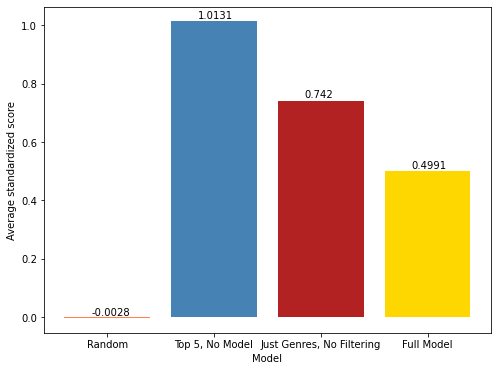

In [49]:
x = ['Random','Top 5, No Model', 'Just Genres, No Filtering', 'Full Model']
y = [-0.0028,1.0131,0.7420,0.4991]
x_pos = np.arange(len(x))
fig = plt.bar(x_pos,y,color=['coral','steelblue','firebrick','gold'])
for index, value in enumerate(y):
    plt.text(index-0.15,value+0.01,s=str(value))
plt.rcParams["figure.figsize"] = (8,6)
plt.xticks(x_pos, x)
plt.xlabel('Model')
plt.ylabel('Average standardized score')
plt.show()

When it comes to coverage, the full model vastly outperforms t5he top 5 models, which is very important for practical applications, as explained earlier.

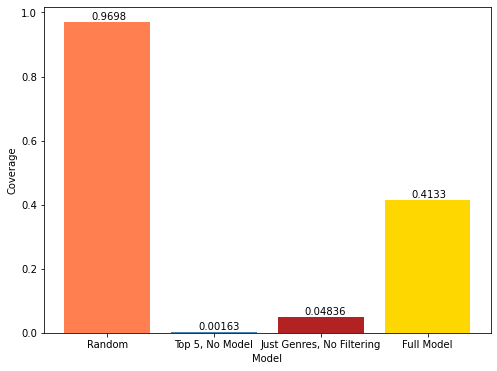

In [50]:
x = ['Random','Top 5, No Model', 'Just Genres, No Filtering', 'Full Model']
y = [0.9698,0.00163,0.04836,0.4133]
x_pos = np.arange(len(x))
fig = plt.bar(x_pos,y,color=['coral','steelblue','firebrick','gold'])
for index, value in enumerate(y):
    plt.text(index-0.15,value+0.01,s=str(value))
plt.rcParams["figure.figsize"] = (8,6)
plt.xticks(x_pos, x)
plt.xlabel('Model')
plt.ylabel('Coverage')
plt.show()

Of the non-random models, the full model is the most performant when it comes to personalization too, outperforming the top 5 among genre clusters model and vastly outperforming the overall top 5 model.

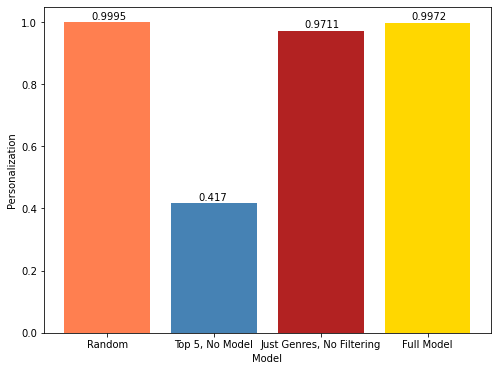

In [51]:
x = ['Random','Top 5, No Model', 'Just Genres, No Filtering', 'Full Model']
y = [0.9995,0.4170,0.9711,0.9972]
x_pos = np.arange(len(x))
fig = plt.bar(x_pos,y,color=['coral','steelblue','firebrick','gold'])
for index, value in enumerate(y):
    plt.text(index-0.15,value+0.01,s=str(value))
plt.rcParams["figure.figsize"] = (8,6)
plt.xticks(x_pos, x)
plt.xlabel('Model')
plt.ylabel('Personalization')
plt.show()

The conclusion to draw is that recommendation is a trade off between the overall user score, and the other factors (voerage and personalization).

This makes sense intuitively. Most people love The Shawshank Redemption and Forrest Gump, so if these two movies were consistently recommended, they'd receive high feedback under the condition that people hadn't already seen them. The problem is that many people already have seen these movies, in addition to other extremely popular movies. A recommender that personalizes choices to the extent that a large part of the available catalog is covered is much more desirable when it comes to giving practical recommendations that will inspire a new user to subscribe to a particular steaming service.

Finally, I will generate some more recommendations for popular movies, in order to show the model in action.

Now that I have constructed the matrix of recommendations, all I need to do is access the relevant row of the matrix to find them, an extremely fast process. The current list of movies could be periodically updated with new releases, and reviews could be scraped from IMDb simultaneously, so that the model stays current.

IMDb is a large and popular website, so there is no issue in relying on it for repeated data acquisition.

In [7]:
#matrix_random = pd.read_csv('personalization_matrix_random.csv')
#matrix_top5 = pd.read_csv('personalization_matrix_top_5.csv')
#matrix_no_words = pd.read_csv('personalization_matrix_no_words.csv')
matrix_full_model = pd.read_csv('personalization.csv',index_col=0)

First, I will check the recommendations for the classic war movie Platoon.

In [76]:
moviename = "platoon"
moviename = moviename.lower()
movie_id = title_id.index[title_id['title'] == moviename].values[0]

movies = matrix_full_model.loc[movie_id,:]
print(movies[movies == 1])

214     1.0
1222    1.0
1242    1.0
1299    1.0
2028    1.0
Name: 1090, dtype: float64


Four of the recommendations are classic movies with military themes, similar to Platoon. The movie "Before The Rain" is a highly acclaimed Macedonian drama movie, which evidently has some overlapping themes with Platoon despite being different on the surface. This is an example of why a more personalized selection is valuable; it's unlikely that most American viewers will have seen this movie, but based on its critical response, it would be a very enjoyable watch.

In [77]:
print(movielens_movies[movielens_movies.index.isin(movies[movies == 1].index)]['title'])

movieId
214         Before the Rain
1222      Full Metal Jacket
1242                  Glory
1299     The Killing Fields
2028    Saving Private Ryan
Name: title, dtype: object


Now, I will show the recommendations for the classic Coen brothers movie No Country For Old Men.

In [20]:
moviename = "no country for old men"
moviename = moviename.lower()
movie_id = title_id.index[title_id['title'] == moviename].values[0]

movies = matrix_full_model.loc[movie_id,:]
print(movies[movies == 1])
print(movielens_movies[movielens_movies.index.isin(movies[movies == 1].index)]['title'])

27866     1.0
32025     1.0
34271     1.0
41863     1.0
174727    1.0
Name: 55820, dtype: float64
movieId
27866                          In My Father's Den
32025                               Walk on Water
34271                               Hustle & Flow
41863     The Three Burials of Melquiades Estrada
174727                                  Good Time
Name: title, dtype: object


Most of the movies here are lesser known. Personally, I have watched The Three Burials of Melquiedes Estrada, and Good Time. The former is a drama with elements of crime in a western setting, similar to No Country, and also stars Tommy Lee Jones. The latter is in an urban setting, but also contains the mix of crime and drama that characterizes No Country. I am not familiar with the other movies, but a cursory look indicates that they are all dramas with mystery or crime/thriller elements, and are all highly regarded by critics. This again indicates the value of drawing from a wide base. It's highly likely the someone who enjoyed No Country For Old Men wouldn't have seen all of these movies, and that they would enjoy at least some of them.

In conclusion, I believe that the results indicate that my model performs well, finding a comfortable middle ground between average user ratings, coverage, and personalization.

In addition to updating the model with more recent movies, other developments of the model could take into account additional information scraped from IMDb, such as the director and principal actors, since many people often consistently enjoy work/performances from the same people.